#### Rozwiązanie Lab 6

In [25]:
from random import randrange

Zbiór danych wejściowych

In [2]:
def generate_random_text(n):
    return "".join([chr(randrange(97, 100)) for _ in range(n)]) + '$'

test_words = [
    "bbb$",
    "aabbabd$",
    "ababcd$",
    "abaababaabaabaabab$",
    generate_random_text(100)]

with open("1997_714_head.txt", "r", encoding='UTF-8') as f:
    test_words.append(f.read())

test_words[-1] = test_words[-1] + '$'

Algorytm KMP wyszukiwania wzorca w tekście do sprawdzania poprawności zaimplementowanych struktur

In [3]:
def build_kmp_table(pattern):
    m = len(pattern)
    pi = [0 for _ in range(m)]
    k = 0
    for i in range(1, m):
        while k > 0 and pattern[i] != pattern[k]:
            k = pi[k-1]
        if pattern[i] == pattern[k]:
            k += 1
        pi[i] = k
    return pi

def kmp(pattern, text):
    m = len(pattern)
    pi = build_kmp_table(pattern)
    ans = []
    i = 0
    j = 0
    while j < len(text):
        while i > 0 and pattern[i] != text[j]:
            i = pi[i - 1]
        if pattern[i] == text[j]:
            i += 1
        if i == m:
            ans.append(j)
            i = pi[-1]
        j += 1
    return ans

Funkcja do obliczania czasu wykonywania procedur. Używam do mierzenia czasu konstrukcji drzew.

In [4]:
from time import perf_counter

def timeit(func):
    def wrapper(*args, **kwargs):
        t1 = perf_counter()
        res = func(*args, **kwargs)
        t2 = perf_counter()
        return res, round(t2 - t1, 4)
    return wrapper

Klasa abstrakcyjna opisująca drzewo. Zawiera metodę konstrukcji drzewa oraz znajdywania konkretnego wzorca

In [5]:
from abc import ABC, abstractmethod

class Tree(ABC):
    def __init__(self, text):
        self.text = text
        self.root = None

    @abstractmethod
    def find_word(self, word):
        pass

    @abstractmethod
    def initiate_trie(self, *args):
        pass

W każdym z drzew używam tej samej klasy do opisu węzłów. Wszystkie pola naraz są wykorzystywane jedynie w algorytmie Ukkonena.
Węzły opisują jednocześnie krawędź, która do nich prowadzi. Atrybut begin oznacza początek fragmentu w oryginalnym tekście do którego odnosi się dana krawędź. Zamiast atrybutu wskazującego na koniec fragmentu, używam zmiennej length, która mówi jak długi jest dany fragment.

In [6]:
from math import inf
from collections import defaultdict

class Node:
    def __init__(self, begin=0, length=inf, link=None):
        self.begin = begin
        self.length = length
        self.edges = defaultdict(bool)
        self.suffix = link

Algorytm budowy trie sufiksów i algorytm sprawdzający czy dany ciąg znaków zawiera się w tekście

In [7]:
def add_word(root, word):
    cur = root
    for letter in word:
        if letter not in cur.edges:
            cur.edges[letter] = Node()
        cur = cur.edges[letter]

@timeit
def build_regular_trie(text):
    root = Node()
    for i in range(len(text)):
        add_word(root, text[i:])
    return root


def find_word_trie(root, word):
    cur = root
    for x in word:
        if x not in cur.edges:
            return False
        cur = cur.edges[x]
    return True

class RegularTrie(Tree):
    def find_word(self, word):
        return find_word_trie(self.root, word)

    def initiate_trie(self):
        self.root, time = build_regular_trie(self.text)
        return time

Algorytm budowy trie sufiksów wykorzystujacy suffix linki.

In [8]:
@timeit
def build_linked_trie(text):
    root = Node()
    deepest = root
    for letter in text:
        cur = deepest
        prev = deepest = cur.edges[letter] = Node(link=root)
        cur = cur.suffix
        while cur is not None:
            if letter not in cur.edges:
                cur.edges[letter] = Node(link=root)
            prev.suffix = cur.edges[letter]
            prev = cur.edges[letter]
            cur = cur.suffix
    return root

class LinkedTrie(RegularTrie):
    def initiate_trie(self):
        self.root, time = build_linked_trie(self.text)
        return time

Algorytm budowy drzewa sufiksów.
Poniższy algorytm buduje strukturę, która ma rozmiar liniowy w zależności od podanego tekstu. W pesymistycznym przypadku czas działania tego algorytmu jest kwadratow, lecz w większości przypadków, czyli dla tekstów w których rzadko powtarzają się dłuższe fragmenty jest znacznie szybszy od wcześniejszych dwóch, a jest znacznie mniej skomplikowany niż algorytm Ukkonena.

In [9]:
def add_suffix(node, ind, text):
    length = 0
    edge = None
    for i in range(ind, len(text)):
        letter = text[i]
        if length == 0:
            if letter not in node.edges:
                node.edges[letter] = Node(i)
                return
            edge = node.edges[letter]
        if text[edge.begin + length] != letter:
            break
        length += 1
        if length >= edge.length:
            node = edge
            length = 0
    else:
        return

    new_node = Node(edge.begin, length)
    node.edges[text[edge.begin]] = new_node
    new_node.edges[text[edge.begin + length]] = edge
    new_node.edges[text[i]] = Node(i)
    edge.begin = edge.begin + length
    edge.length -= length


@timeit
def build_suffix_tree(text):
    root = Node()
    for i in range(len(text)):
        add_suffix(root, i, text)
    return root

Wyszukiwanie słowa w drzewie sufiksów

In [10]:
def find_word(node, text, word):
    length = 0
    edge = None
    for letter in word:
        if length == 0:
            if letter not in node.edges:
                return False
            edge = node.edges[letter]
        if text[edge.begin + length] != letter:
            return False
        length += 1
        if length >= edge.length:
            node = edge
            length = 0
    return True


class SuffixTree1(Tree):
    def find_word(self, word):
        return find_word(self.root, self.text, word)

    def initiate_trie(self):
        self.root, time = build_suffix_tree(self.text)
        return time

##### Algorytm Ukkonena
Główną częścią algorytmu jest klasa opisująca aktywny punkt. Atrybut tree_root zawiera korzeń drzewa sufiksów. Atrybuty length, edge, i node oznaczają odpowiednio aktywną długość, aktywną krawędź oraz aktywny węzeł. Aktywna krawędź nie jest zmienną typu char, lecz intem, który zawiera pozycje danej litery w tekście. Taka reprezentacja ułatwia aktualizowanie aktywnej krawędzi, przy zmianie aktywnego węzła.

In [11]:
class ActivePoint:
    def __init__(self, root, text):
        self.tree_root = root
        self.length = 0
        self.edge = 0
        self.node = root
        self.remainder = 0
        self.text = text

    def update_point(self, node):
        if check := self.length >= node.length:
            self.edge += node.length
            self.length -= node.length
            self.node = node
        return check

    def on_path(self, next_node, letter):
        return self.text[next_node.begin + self.length] == letter

    def split_nodes(self, next_node, letter, pos):
        split = Node(next_node.begin, self.length, self.tree_root)
        self.node.edges[self.text[self.edge]] = split
        leaf = Node(pos)
        split.edges[letter] = leaf
        next_node.begin += self.length
        next_node.length -= self.length
        split.edges[self.text[next_node.begin]] = next_node
        return split

    def follow_suffix_link(self):
        self.remainder -= 1
        if self.node == self.tree_root and self.length > 0:
            self.length -= 1
            self.edge += 1
        else:
            self.node = self.node.suffix


def add_suffix_link(prev, cur):
    if prev is not None:
        prev.suffix = cur
    return cur

@timeit
def ukkonen(text):
    root = Node(0, 0)
    root.suffix = root
    point = ActivePoint(root, text)
    for i, letter in enumerate(text):
        prev = None
        point.remainder += 1
        while point.remainder > 0:
            if point.length == 0:
                point.edge = i
            if next_node := point.node.edges[text[point.edge]]:
                if point.update_point(next_node):
                    continue
                if point.on_path(next_node, letter):
                    point.length += 1
                    _ = add_suffix_link(prev, point.node)
                    break
                split = point.split_nodes(next_node, letter, i)
                prev = add_suffix_link(prev, split)
            else:
                point.node.edges[text[point.edge]] = Node(i)
                prev = add_suffix_link(prev, point.node)

            point.follow_suffix_link()
    return root


class SuffixTree2(SuffixTree1):
    def initiate_trie(self):
        self.root, time = ukkonen(self.text)
        return time

Testowanie poprawności struktur i czasu budowy.
Dla każdego ciągu znaków wybieram jego losowy podciąg i sprawdzam czy znajduje się w drzewie.
Ponadto generuje także testy poprzez dodanie litery wewnątrz jakiegoś podciągu. Algorytmem KMP sprawdzam czy dany wzorzec występuje w tekście.

In [12]:
def test_correctness(text, TreeType, print_mess=True):
    tree = TreeType(text)
    build_time = tree.initiate_trie()
    if print_mess:
        print(f"Text size: {len(text)}, Build time: {build_time}")

    for i in range(min(200, len(text))):
        left = randrange(len(text) - 1)
        right = randrange(left + 1, len(text))
        substring = text[left:right]
        if i % 2:
            m = len(substring) // 2
            substring = substring[:m] + 'a' + substring[m:]
            found = len(kmp(substring, text)) > 0
        else:
            found = True
        assert tree.find_word(substring) == found, "Not OK"
    else:
        if print_mess:
            print("Tests passed\n")
    return build_time

def test(TreeType):
    for t in test_words:
        test_correctness(t, TreeType)

Trie sufiksów

In [13]:
test(RegularTrie)

Text size: 4, Build time: 0.0
Tests passed

Text size: 8, Build time: 0.0
Tests passed

Text size: 7, Build time: 0.0
Tests passed

Text size: 19, Build time: 0.0001
Tests passed

Text size: 101, Build time: 0.0039
Tests passed

Text size: 2482, Build time: 4.3177
Tests passed



Alternatywny algorytm budowy trie sufiksów

In [14]:
test(LinkedTrie)

Text size: 4, Build time: 0.0
Tests passed

Text size: 8, Build time: 0.0
Tests passed

Text size: 7, Build time: 0.0
Tests passed

Text size: 19, Build time: 0.0001
Tests passed

Text size: 101, Build time: 0.0045
Tests passed

Text size: 2482, Build time: 4.3108
Tests passed



Naiwny algorytm budowy drzewa sufiksów

In [15]:
test(SuffixTree1)

Text size: 4, Build time: 0.0
Tests passed

Text size: 8, Build time: 0.0
Tests passed

Text size: 7, Build time: 0.0
Tests passed

Text size: 19, Build time: 0.0001
Tests passed

Text size: 101, Build time: 0.0003
Tests passed

Text size: 2482, Build time: 0.0124
Tests passed



Ukkonen

In [16]:
test(SuffixTree2)

Text size: 4, Build time: 0.0
Tests passed

Text size: 8, Build time: 0.0
Tests passed

Text size: 7, Build time: 0.0
Tests passed

Text size: 19, Build time: 0.0001
Tests passed

Text size: 101, Build time: 0.0003
Tests passed

Text size: 2482, Build time: 0.0073
Tests passed



Widać, że algorytmy korzystające ze skompresowanych drzew sufiksów są dużo szybsze, nawet algorytm, który potencjalnie ma złożoność kwadratową. Przykładem tekstu dla, którego ten algorytm działał by znacznie dłużej byłby tekst złożony z jednej litery.

In [17]:
_ = test_correctness('a'*10000 + '$', SuffixTree1)

Text size: 10001, Build time: 7.962
Tests passed



Wtedy konieczne jest użycie algorytmu Ukkonena.

In [18]:
_ = test_correctness('a'*10000 + '$', SuffixTree2)

Text size: 10001, Build time: 0.0298
Tests passed



#### Czasowe porównanie algorytmów budowy trie i drzew sufiksów

In [19]:
import matplotlib.pyplot as plt

def plot_speed(sizes, TreeTypes, TreeNames):
    times = [[] for _ in TreeTypes]
    for s in sizes:
        text = generate_random_text(s)
        for i in range(len(TreeTypes)):
            times[i].append(test_correctness(text, TreeTypes[i], print_mess=False))

    for t, name in zip(times, TreeNames):
        plt.plot(sizes, t, label=name)

    plt.xlabel('Text size')
    plt.ylabel('Time[s]')
    plt.legend()
    plt.show()

Porównanie klasycznego algorytmu budowy trie i algorytmu z wykorzystaniem suffix linków

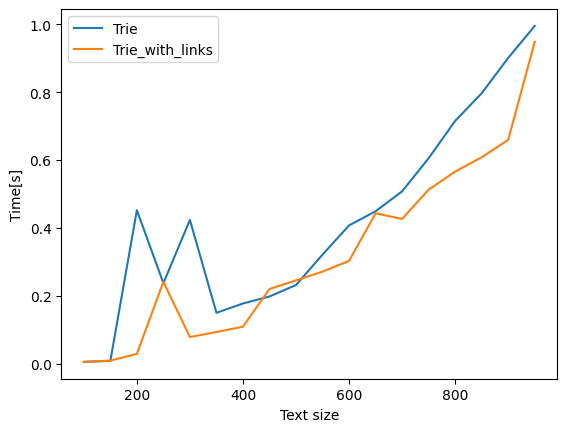

In [21]:
plot_speed([10*i for i in range(10, 100, 5)], [RegularTrie, LinkedTrie], ['Trie', 'Trie_with_links'])

Porównanie algorytmu naiwnego budowy drzewa suffiksów i algorytmu Ukkonena

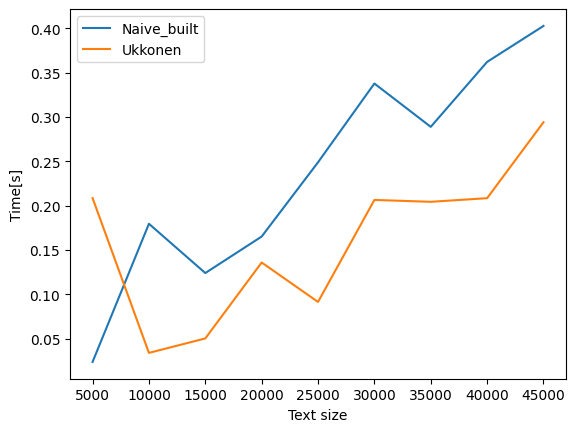

In [23]:
plot_speed([500*i for i in range(10, 100, 10)], [SuffixTree1, SuffixTree2], ['Naive_built', 'Ukkonen'])

#### Wnioski

Wszystkie drzewa pomyślnie przeszły testy, więc można stwierdzić, że struktury zostały zaimplementowane poprawnie. Po wynikach czasowych widać przewagę algorytmów działających na drzewach używających reprezentacji krawędzi poprzez wskaźniki do oryginalnego tekstu. Pomimo tego, że algorytm naiwnej kostrukcji drzewa sufiksów jest w najgorszym przypadku kwadratowy to dla zwykłych tekstów (np. języka naturalnego), gdzie dłuższe fragmenty nie powtarzają się za często, jego czas konstrukcji jest zbliżony do algorytmu ukkonena.